In [1]:
import math
import io
import shutil
import os
import sys
from os import path
import json

import numpy as np
import clip
import cv2
from PIL import Image, ImageChops, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode

import pyiqa

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Setup

In [16]:
# dataset
from helpers.dataset import getDataset

DATASET_DIR = path.abspath(path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid'))
VAE_DIR = path.abspath(path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_pixpat_q4_d256'))

dataset = getDataset(DATASET_DIR)
    
print(dataset[0])

{'image_path': 'D:\\Projects\\MISC\\dataset\\clic2020-professional\\preprocessed\\valid\\alberto-montalesi-176097.png', 'image_name': 'alberto-montalesi-176097', 'semantics': {'object': ['Large Jellyfish', 'Cluster of Small Jellyfish', 'Floating Particles'], 'detail': ['Predominant, translucent with white spots, tentacles.', 'Numerous smaller jellyfish, mostly transparent.', 'Tiny, specklike debris suspended in water.'], 'summary': 'This image captures a mesmerizing scene underwater, featuring a larger jellyfish with distinctive white spots and flowing tentacles, surrounded by numerous smaller jellyfish and floating particles, all set against a deep blue backdrop.'}}


### Helpers

In [6]:
# ALL Helper Functions
def canny_edge_density(image: Image.Image) -> float:
    # Convert the PIL image to a NumPy array
    image_np = np.array(image.convert('L'))  # Convert to grayscale
    # Apply Canny edge detection
    edges = cv2.Canny(image_np, 100, 200)
    # Calculate the number of edge pixels
    edge_pixels = np.sum(edges > 0)
    # Calculate the total number of pixels
    total_pixels = edges.size
    # Calculate the edge density
    edge_density = edge_pixels / total_pixels
    return edge_density

def laplacian_variance(image: Image.Image) -> float:
    # Convert the PIL image to a NumPy array and then to grayscale
    image_np = np.array(image.convert('L'))  # Convert to grayscale
    # Apply the Laplacian operator
    laplacian = cv2.Laplacian(image_np, cv2.CV_64F)
    # Calculate the variance of the Laplacian
    variance = laplacian.var()
    return variance

def normalize_column_minmax(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

def normalize_column_specified(df, column_name, min_val, max_val):
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

def load_img_as_tensor(img_path):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts the image to a tensor with shape (C, H, W) and normalizes to [0, 1]
    ])
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0) # Shape becomes (1, C, H, W)
    return img_tensor

def append_to_file(file_path, text):
    # Open the file in append mode
    with open(file_path, 'a') as file:
        # Write the text to the file
        file.write(text)

def lpips_loss(recon_images, ref_images, iqa_obj):
    if iqa_obj is None:
        iqa_obj = pyiqa.create_metric('lpips', device=device)
    loss = iqa_obj(recon_images, ref_images).item()
    return loss

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to a tensor with shape (C, H, W) and normalizes to [0, 1]
])

### Feature Preparation

In [17]:
# Prepare features from Blind IQA: BRISQUE, NIQE, ClipIQA, MUSIQ, DBCNN, HyperIQA, LIQE
BLIND_IQA = ['brisque', 'niqe', 'clipiqa+', 'musiq', 'dbcnn', 'hyperiqa', 'liqe']

csv_header = ",".join(['id'] + BLIND_IQA) + "\n"

csv_text = f"{csv_header}"
for data in tqdm(dataset):
    img_id = data['image_name']
    vae_img_path = path.join(VAE_DIR, path.basename(data['image_path']))

    img = Image.open(vae_img_path).convert('RGB')
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Shape becomes (1, C, H, W)

    csv_line = f"{img_id}"
    for iqa_name in BLIND_IQA:
        metric = pyiqa.create_metric(iqa_name, device=device)
        score = metric(img_tensor).item()
        csv_line += f",{score}"
    csv_line += "\n"
    csv_text += csv_line

with open(path.join(VAE_DIR, f"feature_biqa.csv"), "w") as iqa_f:
    iqa_f.write(csv_text)

  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


  2%|██                                                                                 | 1/41 [00:09<06:30,  9.76s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


  5%|████                                                                               | 2/41 [00:18<05:55,  9.12s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


  7%|██████                                                                             | 3/41 [00:26<05:32,  8.74s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 10%|████████                                                                           | 4/41 [00:35<05:20,  8.66s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 12%|██████████                                                                         | 5/41 [00:43<05:12,  8.68s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 15%|████████████▏                                                                      | 6/41 [00:52<05:00,  8.60s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 17%|██████████████▏                                                                    | 7/41 [01:01<04:52,  8.61s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 20%|████████████████▏                                                                  | 8/41 [01:09<04:42,  8.56s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 22%|██████████████████▏                                                                | 9/41 [01:18<04:34,  8.59s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 24%|████████████████████                                                              | 10/41 [01:26<04:25,  8.58s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 27%|██████████████████████                                                            | 11/41 [01:35<04:16,  8.54s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 29%|████████████████████████                                                          | 12/41 [01:43<04:06,  8.51s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 32%|██████████████████████████                                                        | 13/41 [01:52<04:00,  8.57s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 34%|████████████████████████████                                                      | 14/41 [02:01<03:52,  8.61s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 37%|██████████████████████████████                                                    | 15/41 [02:09<03:41,  8.53s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 39%|████████████████████████████████                                                  | 16/41 [02:17<03:31,  8.47s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 41%|██████████████████████████████████                                                | 17/41 [02:26<03:22,  8.44s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 44%|████████████████████████████████████                                              | 18/41 [02:34<03:13,  8.43s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 46%|██████████████████████████████████████                                            | 19/41 [02:43<03:06,  8.49s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 49%|████████████████████████████████████████                                          | 20/41 [02:51<02:57,  8.43s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 51%|██████████████████████████████████████████                                        | 21/41 [03:00<02:49,  8.49s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 54%|████████████████████████████████████████████                                      | 22/41 [03:08<02:40,  8.46s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 56%|██████████████████████████████████████████████                                    | 23/41 [03:16<02:31,  8.40s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 59%|████████████████████████████████████████████████                                  | 24/41 [03:25<02:22,  8.39s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 61%|██████████████████████████████████████████████████                                | 25/41 [03:33<02:13,  8.36s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 63%|████████████████████████████████████████████████████                              | 26/41 [03:41<02:04,  8.33s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 66%|██████████████████████████████████████████████████████                            | 27/41 [03:49<01:56,  8.34s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 68%|████████████████████████████████████████████████████████                          | 28/41 [03:58<01:48,  8.32s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 71%|██████████████████████████████████████████████████████████                        | 29/41 [04:07<01:42,  8.51s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 73%|████████████████████████████████████████████████████████████                      | 30/41 [04:15<01:34,  8.60s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 76%|██████████████████████████████████████████████████████████████                    | 31/41 [04:24<01:26,  8.67s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 78%|████████████████████████████████████████████████████████████████                  | 32/41 [04:33<01:18,  8.68s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 80%|██████████████████████████████████████████████████████████████████                | 33/41 [04:42<01:09,  8.67s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 83%|████████████████████████████████████████████████████████████████████              | 34/41 [04:50<01:00,  8.63s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 85%|██████████████████████████████████████████████████████████████████████            | 35/41 [04:59<00:51,  8.59s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 88%|████████████████████████████████████████████████████████████████████████          | 36/41 [05:08<00:43,  8.74s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 90%|██████████████████████████████████████████████████████████████████████████        | 37/41 [05:17<00:35,  8.77s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 93%|████████████████████████████████████████████████████████████████████████████      | 38/41 [05:25<00:26,  8.71s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 95%|██████████████████████████████████████████████████████████████████████████████    | 39/41 [05:34<00:17,  8.62s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


 98%|████████████████████████████████████████████████████████████████████████████████  | 40/41 [05:42<00:08,  8.51s/it]

Loading pretrained model MUSIQ from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\musiq_koniq_ckpt-e95806b9.pth
Loading pretrained model SCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_scnn-7ea73d75.pth
Loading pretrained model DBCNN from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\DBCNN_KonIQ10k-2de81c0a.pth
Loading pretrained model HyperNet from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\HyperIQA-resnet50-koniq10k-c96c41b1.pth
Loading pretrained model LIQE from C:\Users\CrashedBboy\.cache\torch\hub\checkpoints\liqe_koniq.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [05:50<00:00,  8.55s/it]


In [18]:
# Prepare features from Statistical image properties
csv_header = "id,edge-density,blurriness\n"

csv_text = f"{csv_header}"
for data in tqdm(dataset):
    img_id = data['image_name']
    vae_img_path = path.join(VAE_DIR, path.basename(data['image_path']))
    img = Image.open(vae_img_path).convert('RGB')

    edge_density = canny_edge_density(img)
    blurriness = laplacian_variance(img)
    print(f"edge_density: {edge_density}, blurriness: {blurriness}")
    csv_text += f"{img_id},{edge_density},{blurriness}\n"
with open(path.join(VAE_DIR, f"feature_stats.csv"), "w") as iqa_f:
    iqa_f.write(csv_text)

100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 271.25it/s]

edge_density: 0.0707550048828125, blurriness: 411.03926526010036
edge_density: 0.085693359375, blurriness: 2268.004142231308
edge_density: 0.175506591796875, blurriness: 618.77638560161
edge_density: 0.2431488037109375, blurriness: 2165.9496818480548
edge_density: 0.0713958740234375, blurriness: 193.17810089047998
edge_density: 0.07318115234375, blurriness: 574.8620447868016
edge_density: 0.19580078125, blurriness: 1930.4203408323228
edge_density: 0.071624755859375, blurriness: 728.905303803971
edge_density: 0.021209716796875, blurriness: 61.28057962283492
edge_density: 0.11181640625, blurriness: 1215.2513747774065
edge_density: 0.1649322509765625, blurriness: 1532.7103356979787
edge_density: 0.0341339111328125, blurriness: 255.23529750015587
edge_density: 0.1310272216796875, blurriness: 1952.2448330370244
edge_density: 0.078094482421875, blurriness: 373.0499214977026
edge_density: 0.1736602783203125, blurriness: 648.1430696228053
edge_density: 0.0462188720703125, blurriness: 296.06310

In [19]:
# Prepare features of semantic gap
from helpers.clip import clip_score_t_i

clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)
clip_model.eval()

csv_header = "id,semantic-gap\n"

csv_text = f"{csv_header}"
for data in dataset:
    img_id = data['image_name']
    vae_img_path = path.join(VAE_DIR, path.basename(data['image_path']))
    img = Image.open(vae_img_path).convert('RGB')
    semantics = data['semantics']['summary']
    semantic_gap = clip_score_t_i(clip_model, clip_preprocess, semantics, img)
    print(f"{img_id}: {semantic_gap}")
    csv_text += f"{img_id},{semantic_gap}\n"
with open(path.join(VAE_DIR, f"feature_clip.csv"), "w") as iqa_f:
    iqa_f.write(csv_text)

alberto-montalesi-176097: 0.30859375
alejandro-escamilla-6: 0.335693359375
ales-krivec-15949: 0.35498046875
alexander-shustov-73: 0.382568359375
allef-vinicius-109434: 0.336181640625
amy-zhang-15940: 0.3662109375
andrew-ruiz-376: 0.31396484375
benjamin-sloth-lindgreen-705: 0.305419921875
casey-fyfe-999: 0.2734375
clem-onojeghuo-33741: 0.270751953125
daniel-robert-405: 0.29638671875
davide-ragusa-716: 0.317626953125
dogancan-ozturan-395: 0.316162109375
felix-russell-saw-140699: 0.438232421875
gian-reto-tarnutzer-45212: 0.36279296875
jared-erondu-21325: 0.38134765625
jason-briscoe-149782: 0.32275390625
jeremy-cai-1174: 0.335205078125
juskteez-vu-1041: 0.295166015625
kazuend-28556: 0.354736328125
lobostudio-hamburg-75377: 0.278564453125
martin-wessely-211: 0.298095703125
martyn-seddon-220: 0.353515625
michael-durana-82941: 0.321044921875
mullermarc-184: 0.351806640625
nomao-saeki-33553: 0.270751953125
paul-itkin-46101: 0.323486328125
philipp-reiner-207: 0.337890625
philippe-wuyts-45997: 0

### Load Features

In [20]:
csv_clip = "feature_clip.csv"
csv_stats = "feature_stats.csv"
csv_biqa = "feature_biqa.csv"
csv_bitrate = "bpp_avg_0.4796342304567011.csv"

# Load the CSV files into DataFrames
df_clip = pd.read_csv(path.join(VAE_DIR, csv_clip))
df_stats = pd.read_csv(path.join(VAE_DIR, csv_stats))
df_biqa = pd.read_csv(path.join(VAE_DIR, csv_biqa))
df_bitrate = pd.read_csv(path.join(VAE_DIR, csv_bitrate))

df_stats = df_stats.drop(columns=['id'])
df_biqa = df_biqa.drop(columns=['id'])
df_bitrate = df_bitrate.drop(columns=['ID'])

# Concatenate the DataFrames
# Assuming both DataFrames have the same number of rows and they are aligned by index
df_combined = pd.concat([df_clip, df_stats, df_biqa, df_bitrate], axis=1)

csv_combined = "feature_combined.csv"
df_combined.to_csv(path.join(VAE_DIR, csv_combined), index=False)

df_combined.head()

,id,semantic-gap,edge-density,blurriness,brisque,niqe,clipiqa+,musiq,dbcnn,hyperiqa,liqe,BPP
0,alberto-montalesi-176097,0.308594,0.070755,411.039265,37.490906,4.951113,0.576393,57.921844,0.492117,0.539452,3.362415,0.379289
1,alejandro-escamilla-6,0.335693,0.085693,2268.004142,51.437195,9.087766,0.645314,71.042862,0.602597,0.744501,4.978001,0.381267
2,ales-krivec-15949,0.354980,0.175507,618.776386,30.319519,10.422622,0.716107,61.538631,0.537303,0.675694,4.711940,0.623514
3,alexander-shustov-73,0.382568,0.243149,2165.949682,21.362000,10.463087,0.748531,67.624298,0.723978,0.758628,4.994694,1.010174
4,allef-vinicius-109434,0.336182,0.071396,193.178101,34.738953,6.161176,0.423833,51.012897,0.449955,0.616281,2.594617,0.291117


In [5]:
# Normailization
df_combined = normalize_column_minmax(df_combined, 'blurriness')
df_combined = normalize_column_minmax(df_combined, 'niqe')
df_combined = normalize_column_minmax(df_combined, 'liqe')
df_combined = normalize_column_minmax(df_combined, 'BPP')

df_combined = normalize_column_specified(df_combined, 'brisque', 0, 100)
df_combined = normalize_column_specified(df_combined, 'musiq', 0, 100)

df_combined.head()

,id,semantic-gap,edge-density,blurriness,brisque,niqe,clipiqa+,musiq,dbcnn,hyperiqa,liqe,BPP
0,alberto-montalesi-176097,0.299805,0.052841,0.092202,0.368893,0.117137,0.543226,0.492023,0.426933,0.445376,0.256720,0.339552
1,alejandro-escamilla-6,0.319092,0.075531,0.579676,0.448796,0.348111,0.618631,0.608919,0.521413,0.652028,0.803011,0.371936
2,ales-krivec-15949,0.351074,0.144104,0.121255,0.417829,0.517643,0.610768,0.501252,0.476411,0.519358,0.619869,0.692136
3,alexander-shustov-73,0.390869,0.163055,0.357770,0.400930,0.281976,0.496258,0.592413,0.513442,0.611146,0.733883,0.769012
4,allef-vinicius-109434,0.321289,0.043472,0.033864,0.446652,0.144387,0.286983,0.318442,0.375770,0.444894,0.000000,0.223364


In [6]:
INPUT_DIM = df_combined.shape[1]-1
print(f"Input Dimension: {INPUT_DIM}")

Input Dimension: 11


In [9]:
csv_combined = "feature_combined.csv"
df_combined.to_csv(path.join(VAE_DIR, csv_combined), index=False)

### Network And Loss Function

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=1):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# # Hyperparameters
# input_dim = 11
# output_dim = 1

# # Initialize model
# model = FullyConnectedNN(input_dim, output_dim)

In [77]:
# define loss function: steps with LPIPS
class StepWithLPIPSLoss(nn.Module):
    def __init__(self, loss_map, step_lambda, prediction_range):
        super(StepWithLPIPSLoss, self).__init__()
        self.loss_map = loss_map
        self.step_lambda = step_lambda
        self.predict_min, self.predict_max = prediction_range

    # shape predicted_value: (BATCH_SIZE=1,1)
    def forward(self, predicted_value, image_id):
        loss_map_for_image = self.loss_map[image_id]
        min_key = float(min(loss_map_for_image, key=loss_map_for_image.get))
        min_key = (min_key-self.predict_min)/(self.predict_max-self.predict_min)
        return self.step_lambda*predicted_value[0,0]**2 + (predicted_value[0,0]-min_key)**2

    def interpolate_loss_map(self, predicted_value, loss_map):
        keys = sorted(loss_map.keys())
        values = torch.tensor([loss_map[key] for key in keys], dtype=predicted_value.dtype, device=predicted_value.device)
        keys = torch.tensor([float(k) for k in keys], dtype=predicted_value.dtype, device=predicted_value.device)

        # Find the indices of the two points we are interpolating between
        lower_idx = torch.sum(predicted_value >= keys) - 1
        upper_idx = lower_idx + 1

        # Ensure the indices are within bounds
        lower_idx = torch.clamp(lower_idx, 0, len(keys) - 1)
        upper_idx = torch.clamp(upper_idx, 0, len(keys) - 1)

        # Get the values for interpolation
        lower_key = keys[lower_idx]
        upper_key = keys[upper_idx]
        lower_value = values[lower_idx]
        upper_value = values[upper_idx]
        # Linear interpolation
        if upper_key != lower_key:
            weight = (predicted_value - lower_key) / (upper_key - lower_key)
            interpolated_value = lower_value * (1 - weight) + upper_value * weight
        else:
            interpolated_value = lower_value

        return interpolated_value

In [65]:
LOSS_MAP_CFG = None
with open(path.join('results','AllCFGs', 'lpips_map.json'), 'r') as cfg_loss_f:
    LOSS_MAP_CFG = json.load(cfg_loss_f)

LOSS_MAP_STEP = None
with open(path.join('results', 'AllDiffSteps', 'lpips_map.json'), 'r') as step_loss_f:
    LOSS_MAP_STEP = json.load(step_loss_f)

### Do Reconstructions with All Possible Diffusion Steps/CFG

In [5]:
# Add the root directory of the repository to the Python path
repo_root = os.path.abspath(os.path.join('DiffBIR'))
sys.path.insert(0, repo_root)
from DiffBIR.sr_helper import initAllDiffusionModel
pipeline_upscale_2 = initAllDiffusionModel(upscale=2)
torch.cuda.empty_cache()

# LPIPS
iqa_obj = pyiqa.create_metric('lpips', device=device)

use sdp attention as default
keep default attention mode
[3, 3, 64, 23, 32, 4]
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is None and using 20 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is 1024 and

In [7]:
############################
## Dynamic Diffusion Steps
############################

PREDEFINED_STEPS = [60,70,80]

POS_PROMPT = "Hyper Detail, Masterpiece, 4K"
NEG_PROMPT = "Blurry, Low Quality"

result_dir = path.join('results', 'AllDiffSteps')
os.makedirs(result_dir, exist_ok=False)

# loss map
lpips_map_path = path.join(result_dir, "lpips_map.json")
lpips_map = {}

for diff_step in PREDEFINED_STEPS:
    for data in dataset:
        # prepare data
        img_id = data['image_name']
        print(f"{img_id}: {diff_step} steps")
        semantics = data['semantics']['summary']
        ref_img_path = data['image_path']
        ref_img_tensor = load_img_as_tensor(ref_img_path) # (BATCH_SIZE=1, C, H, W)
        vae_img_path = path.join(VAE_DIR, path.basename(ref_img_path))

        CFG = 4

        vae_img = np.array(Image.open(vae_img_path).convert("RGB"))
        sample_img, sample_tensor = pipeline_upscale_2.run(
            vae_img[None], diff_step, 1.0, False,
            512, 256,
            f"{semantics}, {POS_PROMPT}", NEG_PROMPT, CFG,
            False
        )

        recon_tensor = sample_tensor # (BATCH_SIZE=1, C, H, W)

        recon_img = Image.fromarray(sample_img[0])
        recon_img.save(path.join(result_dir, f"{data['image_name']}.step_{diff_step}.png"))

        loss = lpips_loss(recon_tensor, ref_img_tensor, iqa_obj)

        if img_id not in lpips_map.keys():
            lpips_map[img_id] = {}
        lpips_map[img_id][diff_step] = loss
        
        with open(lpips_map_path, 'w') as json_file:
            json.dump(lpips_map, json_file, indent=4)

alberto-montalesi-176097: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


alejandro-escamilla-6: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:14<00:00, 11.24s/it]


ales-krivec-15949: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


alexander-shustov-73: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


allef-vinicius-109434: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


amy-zhang-15940: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.20s/it]


andrew-ruiz-376: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.22s/it]


benjamin-sloth-lindgreen-705: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


casey-fyfe-999: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


clem-onojeghuo-33741: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:13<00:00, 11.22s/it]


daniel-robert-405: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


davide-ragusa-716: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:13<00:00, 11.22s/it]


dogancan-ozturan-395: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


felix-russell-saw-140699: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


gian-reto-tarnutzer-45212: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


jared-erondu-21325: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


jason-briscoe-149782: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


jeremy-cai-1174: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


juskteez-vu-1041: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


kazuend-28556: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


lobostudio-hamburg-75377: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


martin-wessely-211: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:19<00:00, 11.33s/it]


martyn-seddon-220: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:13<00:00, 11.22s/it]


michael-durana-82941: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


mullermarc-184: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


nomao-saeki-33553: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


paul-itkin-46101: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.20s/it]


philipp-reiner-207: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:13<00:00, 11.22s/it]


philippe-wuyts-45997: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.20s/it]


roberto-nickson-48063: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.20s/it]


schicka-307: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.20s/it]


sergey-zolkin-1045: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


sergey-zolkin-21232: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:13<00:00, 11.22s/it]


stefan-kunze-26931: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


thong-vo-428: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


todd-quackenbush-222: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


todd-quackenbush-27493: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


veeterzy-82537: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:13<00:00, 11.22s/it]


vita-vilcina-3055: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


wojciech-szaturski-3611: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


zugr-108: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [11:12<00:00, 11.21s/it]


alberto-montalesi-176097: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:06<00:00, 11.24s/it]


alejandro-escamilla-6: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.23s/it]


ales-krivec-15949: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


alexander-shustov-73: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


allef-vinicius-109434: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


amy-zhang-15940: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.23s/it]


andrew-ruiz-376: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


benjamin-sloth-lindgreen-705: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


casey-fyfe-999: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


clem-onojeghuo-33741: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


daniel-robert-405: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


davide-ragusa-716: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


dogancan-ozturan-395: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


felix-russell-saw-140699: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:08<00:00, 11.27s/it]


gian-reto-tarnutzer-45212: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:07<00:00, 11.25s/it]


jared-erondu-21325: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


jason-briscoe-149782: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


jeremy-cai-1174: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:06<00:00, 11.23s/it]


juskteez-vu-1041: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


kazuend-28556: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.23s/it]


lobostudio-hamburg-75377: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:06<00:00, 11.23s/it]


martin-wessely-211: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


martyn-seddon-220: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


michael-durana-82941: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:04<00:00, 11.21s/it]


mullermarc-184: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:05<00:00, 11.22s/it]


nomao-saeki-33553: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:09<00:00, 11.27s/it]


paul-itkin-46101: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:14<00:00, 11.35s/it]


philipp-reiner-207: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:17<00:00, 11.39s/it]


philippe-wuyts-45997: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:13<00:00, 11.33s/it]


roberto-nickson-48063: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


schicka-307: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


sergey-zolkin-1045: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.33s/it]


sergey-zolkin-21232: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


stefan-kunze-26931: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.33s/it]


thong-vo-428: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


todd-quackenbush-222: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


todd-quackenbush-27493: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


veeterzy-82537: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:13<00:00, 11.33s/it]


vita-vilcina-3055: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


wojciech-szaturski-3611: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


zugr-108: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [13:12<00:00, 11.32s/it]


alberto-montalesi-176097: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:09<00:00, 11.36s/it]


alejandro-escamilla-6: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:12<00:00, 11.41s/it]


ales-krivec-15949: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:12<00:00, 11.40s/it]


alexander-shustov-73: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:12<00:00, 11.41s/it]


allef-vinicius-109434: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:09<00:00, 11.37s/it]


amy-zhang-15940: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


andrew-ruiz-376: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


benjamin-sloth-lindgreen-705: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


casey-fyfe-999: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


clem-onojeghuo-33741: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


daniel-robert-405: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


davide-ragusa-716: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


dogancan-ozturan-395: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


felix-russell-saw-140699: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:09<00:00, 11.37s/it]


gian-reto-tarnutzer-45212: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


jared-erondu-21325: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.34s/it]


jason-briscoe-149782: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


jeremy-cai-1174: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


juskteez-vu-1041: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


kazuend-28556: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


lobostudio-hamburg-75377: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


martin-wessely-211: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


martyn-seddon-220: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


michael-durana-82941: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.34s/it]


mullermarc-184: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


nomao-saeki-33553: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


paul-itkin-46101: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:09<00:00, 11.37s/it]


philipp-reiner-207: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


philippe-wuyts-45997: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:07<00:00, 11.34s/it]


roberto-nickson-48063: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


schicka-307: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


sergey-zolkin-1045: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


sergey-zolkin-21232: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


stefan-kunze-26931: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


thong-vo-428: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.34s/it]


todd-quackenbush-222: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:07<00:00, 11.34s/it]


todd-quackenbush-27493: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


veeterzy-82537: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


vita-vilcina-3055: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:07<00:00, 11.34s/it]


wojciech-szaturski-3611: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


zugr-108: 80 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 80/80 [15:06<00:00, 11.33s/it]


In [ ]:
############################
## Dynamic Diffusion CFG
############################

PREDEFINED_CFG = [0, 2, 4, 6, 8, 10]

POS_PROMPT = "Hyper Detail, Masterpiece, 4K"
NEG_PROMPT = "Blurry, Low Quality"

result_dir = path.join('results', 'AllCFGs')
os.makedirs(result_dir, exist_ok=False)

# loss map
lpips_map_path = path.join(result_dir, "lpips_map.json")
lpips_map = {}

for diff_cfg in PREDEFINED_CFG:
    for data in dataset:
        # prepare data
        img_id = data['image_name']
        print(f"{img_id}: {diff_cfg} CFG")
        semantics = data['semantics']['summary']
        ref_img_path = data['image_path']
        ref_img_tensor = load_img_as_tensor(ref_img_path) # (BATCH_SIZE=1, C, H, W)
        vae_img_path = path.join(VAE_DIR, path.basename(ref_img_path))

        vae_img = np.array(Image.open(vae_img_path).convert("RGB"))
        sample_img, sample_tensor = pipeline_upscale_2.run(
            vae_img[None], 20, 1.0, False,
            512, 256,
            f"{semantics}, {POS_PROMPT}", NEG_PROMPT, diff_cfg,
            False
        )

        recon_tensor = sample_tensor # (BATCH_SIZE=1, C, H, W)

        recon_img = Image.fromarray(sample_img[0])
        recon_img.save(path.join(result_dir, f"{data['image_name']}.cfg_{diff_cfg}.png"))

        loss = lpips_loss(recon_tensor, ref_img_tensor, iqa_obj)

        if img_id not in lpips_map.keys():
            lpips_map[img_id] = {}
        lpips_map[img_id][diff_cfg] = loss
        
        with open(lpips_map_path, 'w') as json_file:
            json.dump(lpips_map, json_file, indent=4)

alberto-montalesi-176097: 0 CFG


C:\Users\CrashedBboy\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:22<00:00, 13.13s/it]


alejandro-escamilla-6: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:35<00:00, 13.78s/it]


ales-krivec-15949: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:39<00:00, 13.97s/it]


alexander-shustov-73: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.45s/it]


allef-vinicius-109434: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [06:34<00:00, 19.71s/it]


amy-zhang-15940: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.39s/it]


andrew-ruiz-376: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.47s/it]


benjamin-sloth-lindgreen-705: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.24s/it]


casey-fyfe-999: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.17s/it]


clem-onojeghuo-33741: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.22s/it]


daniel-robert-405: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.35s/it]


davide-ragusa-716: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.19s/it]


dogancan-ozturan-395: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:11<00:00, 12.58s/it]


felix-russell-saw-140699: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.93s/it]


gian-reto-tarnutzer-45212: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.09s/it]


jared-erondu-21325: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.43s/it]


jason-briscoe-149782: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.46s/it]


jeremy-cai-1174: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:19<00:00, 12.95s/it]


juskteez-vu-1041: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.19s/it]


kazuend-28556: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.52s/it]


lobostudio-hamburg-75377: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.52s/it]


martin-wessely-211: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]


martyn-seddon-220: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


michael-durana-82941: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


mullermarc-184: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


nomao-saeki-33553: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


paul-itkin-46101: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


philipp-reiner-207: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.14s/it]


philippe-wuyts-45997: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


roberto-nickson-48063: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


schicka-307: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.31s/it]


sergey-zolkin-1045: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.38s/it]


sergey-zolkin-21232: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


stefan-kunze-26931: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


thong-vo-428: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


todd-quackenbush-222: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


todd-quackenbush-27493: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


veeterzy-82537: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


vita-vilcina-3055: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


wojciech-szaturski-3611: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


zugr-108: 0 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


alberto-montalesi-176097: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


alejandro-escamilla-6: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


ales-krivec-15949: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


alexander-shustov-73: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


allef-vinicius-109434: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


amy-zhang-15940: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


andrew-ruiz-376: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


benjamin-sloth-lindgreen-705: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]


casey-fyfe-999: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


clem-onojeghuo-33741: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


daniel-robert-405: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


davide-ragusa-716: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


dogancan-ozturan-395: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


felix-russell-saw-140699: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


gian-reto-tarnutzer-45212: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


jared-erondu-21325: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.40s/it]


jason-briscoe-149782: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.44s/it]


jeremy-cai-1174: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.24s/it]


juskteez-vu-1041: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


kazuend-28556: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


lobostudio-hamburg-75377: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


martin-wessely-211: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


martyn-seddon-220: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]


michael-durana-82941: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


mullermarc-184: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


nomao-saeki-33553: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


paul-itkin-46101: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


philipp-reiner-207: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


philippe-wuyts-45997: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


roberto-nickson-48063: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


schicka-307: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


sergey-zolkin-1045: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


sergey-zolkin-21232: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


stefan-kunze-26931: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


thong-vo-428: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


todd-quackenbush-222: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


todd-quackenbush-27493: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


veeterzy-82537: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


vita-vilcina-3055: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


wojciech-szaturski-3611: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.23s/it]


zugr-108: 2 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.28s/it]


alberto-montalesi-176097: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


alejandro-escamilla-6: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


ales-krivec-15949: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


alexander-shustov-73: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


allef-vinicius-109434: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


amy-zhang-15940: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


andrew-ruiz-376: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


benjamin-sloth-lindgreen-705: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


casey-fyfe-999: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


clem-onojeghuo-33741: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.34s/it]


daniel-robert-405: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


davide-ragusa-716: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.35s/it]


dogancan-ozturan-395: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


felix-russell-saw-140699: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


gian-reto-tarnutzer-45212: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


jared-erondu-21325: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.26s/it]


jason-briscoe-149782: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


jeremy-cai-1174: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.19s/it]


juskteez-vu-1041: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


kazuend-28556: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.23s/it]


lobostudio-hamburg-75377: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


martin-wessely-211: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


martyn-seddon-220: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


michael-durana-82941: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


mullermarc-184: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.21s/it]


nomao-saeki-33553: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


paul-itkin-46101: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.26s/it]


philipp-reiner-207: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


philippe-wuyts-45997: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


roberto-nickson-48063: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


schicka-307: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.19s/it]


sergey-zolkin-1045: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


sergey-zolkin-21232: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


stefan-kunze-26931: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


thong-vo-428: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


todd-quackenbush-222: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


todd-quackenbush-27493: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.24s/it]


veeterzy-82537: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


vita-vilcina-3055: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


wojciech-szaturski-3611: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


zugr-108: 4 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


alberto-montalesi-176097: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


alejandro-escamilla-6: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


ales-krivec-15949: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.41s/it]


alexander-shustov-73: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


allef-vinicius-109434: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


amy-zhang-15940: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


andrew-ruiz-376: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


benjamin-sloth-lindgreen-705: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.34s/it]


casey-fyfe-999: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


clem-onojeghuo-33741: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


daniel-robert-405: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.31s/it]


davide-ragusa-716: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.22s/it]


dogancan-ozturan-395: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


felix-russell-saw-140699: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


gian-reto-tarnutzer-45212: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


jared-erondu-21325: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


jason-briscoe-149782: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


jeremy-cai-1174: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.26s/it]


juskteez-vu-1041: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


kazuend-28556: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


lobostudio-hamburg-75377: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.21s/it]


martin-wessely-211: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


martyn-seddon-220: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


michael-durana-82941: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


mullermarc-184: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


nomao-saeki-33553: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


paul-itkin-46101: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


philipp-reiner-207: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


philippe-wuyts-45997: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


roberto-nickson-48063: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


schicka-307: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


sergey-zolkin-1045: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


sergey-zolkin-21232: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.37s/it]


stefan-kunze-26931: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


thong-vo-428: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


todd-quackenbush-222: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


todd-quackenbush-27493: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


veeterzy-82537: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


vita-vilcina-3055: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.23s/it]


wojciech-szaturski-3611: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.27s/it]


zugr-108: 6 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


alberto-montalesi-176097: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


alejandro-escamilla-6: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


ales-krivec-15949: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


alexander-shustov-73: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


allef-vinicius-109434: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.28s/it]


amy-zhang-15940: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.34s/it]


andrew-ruiz-376: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


benjamin-sloth-lindgreen-705: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.34s/it]


casey-fyfe-999: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


clem-onojeghuo-33741: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


daniel-robert-405: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


davide-ragusa-716: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


dogancan-ozturan-395: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.42s/it]


felix-russell-saw-140699: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


gian-reto-tarnutzer-45212: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


jared-erondu-21325: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


jason-briscoe-149782: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.36s/it]


jeremy-cai-1174: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


juskteez-vu-1041: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.23s/it]


kazuend-28556: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


lobostudio-hamburg-75377: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.14s/it]


martin-wessely-211: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


martyn-seddon-220: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


michael-durana-82941: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]


mullermarc-184: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


nomao-saeki-33553: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


paul-itkin-46101: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


philipp-reiner-207: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.23s/it]


philippe-wuyts-45997: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


roberto-nickson-48063: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


schicka-307: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


sergey-zolkin-1045: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


sergey-zolkin-21232: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


stefan-kunze-26931: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.34s/it]


thong-vo-428: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


todd-quackenbush-222: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.45s/it]


todd-quackenbush-27493: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


veeterzy-82537: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


vita-vilcina-3055: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.41s/it]


wojciech-szaturski-3611: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


zugr-108: 8 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.33s/it]


alberto-montalesi-176097: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.32s/it]


alejandro-escamilla-6: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


ales-krivec-15949: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


alexander-shustov-73: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.15s/it]


allef-vinicius-109434: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


amy-zhang-15940: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


andrew-ruiz-376: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.15s/it]


benjamin-sloth-lindgreen-705: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.25s/it]


casey-fyfe-999: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.80s/it]


clem-onojeghuo-33741: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [05:07<00:00, 15.37s/it]


daniel-robert-405: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [05:31<00:00, 16.56s/it]


davide-ragusa-716: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:52<00:00, 14.64s/it]


dogancan-ozturan-395: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.53s/it]


felix-russell-saw-140699: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.78s/it]


gian-reto-tarnutzer-45212: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:19<00:00, 13.00s/it]


jared-erondu-21325: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.09s/it]


jason-briscoe-149782: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.85s/it]


jeremy-cai-1174: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:12<00:00, 12.63s/it]


juskteez-vu-1041: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.43s/it]


kazuend-28556: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.44s/it]


lobostudio-hamburg-75377: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.77s/it]


martin-wessely-211: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:52<00:00, 14.64s/it]


martyn-seddon-220: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [05:00<00:00, 15.02s/it]


michael-durana-82941: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [05:02<00:00, 15.10s/it]


mullermarc-184: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:56<00:00, 14.83s/it]


nomao-saeki-33553: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:59<00:00, 15.00s/it]


paul-itkin-46101: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:36<00:00, 13.81s/it]


philipp-reiner-207: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:35<00:00, 13.78s/it]


philippe-wuyts-45997: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:17<00:00, 12.89s/it]


roberto-nickson-48063: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:13<00:00, 12.68s/it]


schicka-307: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.24s/it]


sergey-zolkin-1045: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:11<00:00, 12.58s/it]


sergey-zolkin-21232: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:13<00:00, 12.69s/it]


stefan-kunze-26931: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.90s/it]


thong-vo-428: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.46s/it]


todd-quackenbush-222: 10 CFG


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.32s/it]


todd-quackenbush-27493: 10 CFG


Spaced Sampler:  85%|████████████████████████████████████████████████████████          | 17/20 [03:46<00:39, 13.29s/it]

### Training Pipeline: Dynamic Diffusion Steps

In [66]:
DIFF_STEP_MIN = 2
DIFF_STEP_MAX = 80
torch.autograd.set_detect_anomaly(True)
def scale_diff_step(prediction):
    return prediction*(DIFF_STEP_MAX - DIFF_STEP_MIN) + DIFF_STEP_MIN
def train_diffstep(num_epoch, lr, step_lambda, checkpoint_path, name, hidden_dim):

    if name == None:
        name = f"DynDiff_lambda{step_lambda}_lr{lr}_hid{hidden_dim}"

    result_dir = path.join('results', name)
    print(f"[[[[[ Result Directory: {result_dir} ]]]]]")
    os.makedirs(result_dir, exist_ok=(checkpoint_path != None))
    
    if checkpoint_path == None:
        model = FullyConnectedNN(input_dim=INPUT_DIM, hidden_dim=hidden_dim, output_dim=1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        epoch_start = 0
    else:
        checkpoint = torch.load(checkpoint_path)
        # Reinitialize the model and optimizer
        model = FullyConnectedNN(input_dim=INPUT_DIM, hidden_dim=hidden_dim, output_dim=1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # Load the state dictionaries
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']
        
    criterion = StepWithLPIPSLoss(
        loss_map=LOSS_MAP_STEP,
        step_lambda=step_lambda,
        prediction_range=(DIFF_STEP_MIN,DIFF_STEP_MAX)).to(device) # usage: loss = loss_fn(prediction, "img_id", (2,80))

    losses = []
    steps = []
    for epoch in range(epoch_start,epoch_start+num_epoch):
        record_file_path = path.join(result_dir, f"record_ep_{epoch}.csv")
        append_to_file(record_file_path, 'id,train_loss,step\n')
        model.train()
        loss_sum = 0
        step_sum = 0
        for data in dataset:
            # prepare data
            img_id = data['image_name']
            # semantics = data['semantics']['summary']
            df_row = df_combined[df_combined['id'] == img_id].drop(columns=['id'])
            input_tensor = torch.tensor(df_row.values, dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            outputs = model(input_tensor) # shape: (BATCH SIZE=1, 1)

            # outputs[0,0] = outputs[0,0]*(DIFF_STEP_MAX - DIFF_STEP_MIN) + DIFF_STEP_MIN
            diff_step = scale_diff_step(outputs[0,0].item())

            loss = criterion(outputs, img_id)
            loss.backward()
            optimizer.step()

            append_to_file(record_file_path, f'{img_id},{loss.item()},{diff_step}\n')
            loss_sum += loss.item()
            step_sum += diff_step

        print(f"Epoch: {epoch}, Average Loss = {loss_sum/len(dataset):.4f}, Average Diff Step = {step_sum/len(dataset):.4f}")
        losses.append( loss_sum/len(dataset) )
        steps.append( step_sum/len(dataset) )
        # Save the model checkpoint
        checkpoint_path = path.join(result_dir, f'model_checkpoint_ep_{epoch}.pth')
        torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot([(e+1) for e in range(num_epoch)], losses, linestyle='-')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss over Epochs')
    ax[0].grid(True)
    ax[1].plot([(e+1) for e in range(num_epoch)], steps, linestyle='-')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Step')
    ax[1].set_title('Training Steps over Epochs')
    ax[1].grid(True)
    plt.tight_layout()
    plt.savefig(path.join(result_dir, "training_loss_step.png"))
    plt.show()
    
    return model

[[[[[ Result Directory: results\DynDiff_lambda0_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.1446, Average Diff Step = 45.1285
Epoch: 1, Average Loss = 0.1439, Average Diff Step = 45.6156
Epoch: 2, Average Loss = 0.1435, Average Diff Step = 45.9368
Epoch: 3, Average Loss = 0.1433, Average Diff Step = 46.2142
Epoch: 4, Average Loss = 0.1430, Average Diff Step = 46.4940
Epoch: 5, Average Loss = 0.1428, Average Diff Step = 46.7477
Epoch: 6, Average Loss = 0.1426, Average Diff Step = 46.9804
Epoch: 7, Average Loss = 0.1424, Average Diff Step = 47.1836
Epoch: 8, Average Loss = 0.1422, Average Diff Step = 47.3673
Epoch: 9, Average Loss = 0.1420, Average Diff Step = 47.5222
Epoch: 10, Average Loss = 0.1419, Average Diff Step = 47.6604
Epoch: 11, Average Loss = 0.1418, Average Diff Step = 47.7793
Epoch: 12, Average Loss = 0.1416, Average Diff Step = 47.8814
Epoch: 13, Average Loss = 0.1415, Average Diff Step = 47.9751
Epoch: 14, Average Loss = 0.1413, Average Diff Step = 48.0447
Epoch: 15, A

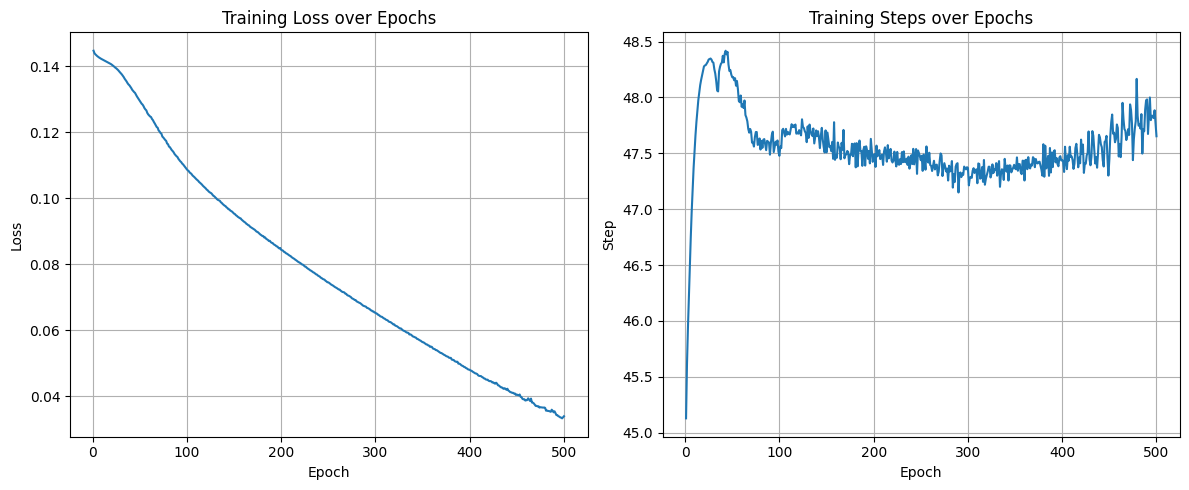

[[[[[ Result Directory: results\DynDiff_lambda0.01_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.1546, Average Diff Step = 40.3614
Epoch: 1, Average Loss = 0.1511, Average Diff Step = 41.7956
Epoch: 2, Average Loss = 0.1485, Average Diff Step = 43.1346
Epoch: 3, Average Loss = 0.1467, Average Diff Step = 44.3604
Epoch: 4, Average Loss = 0.1456, Average Diff Step = 45.3361
Epoch: 5, Average Loss = 0.1449, Average Diff Step = 46.0833
Epoch: 6, Average Loss = 0.1444, Average Diff Step = 46.6162
Epoch: 7, Average Loss = 0.1441, Average Diff Step = 46.9832
Epoch: 8, Average Loss = 0.1438, Average Diff Step = 47.2282
Epoch: 9, Average Loss = 0.1436, Average Diff Step = 47.4199
Epoch: 10, Average Loss = 0.1433, Average Diff Step = 47.5236
Epoch: 11, Average Loss = 0.1431, Average Diff Step = 47.6000
Epoch: 12, Average Loss = 0.1428, Average Diff Step = 47.6392
Epoch: 13, Average Loss = 0.1426, Average Diff Step = 47.6702
Epoch: 14, Average Loss = 0.1423, Average Diff Step = 47.6736
Epoch: 15

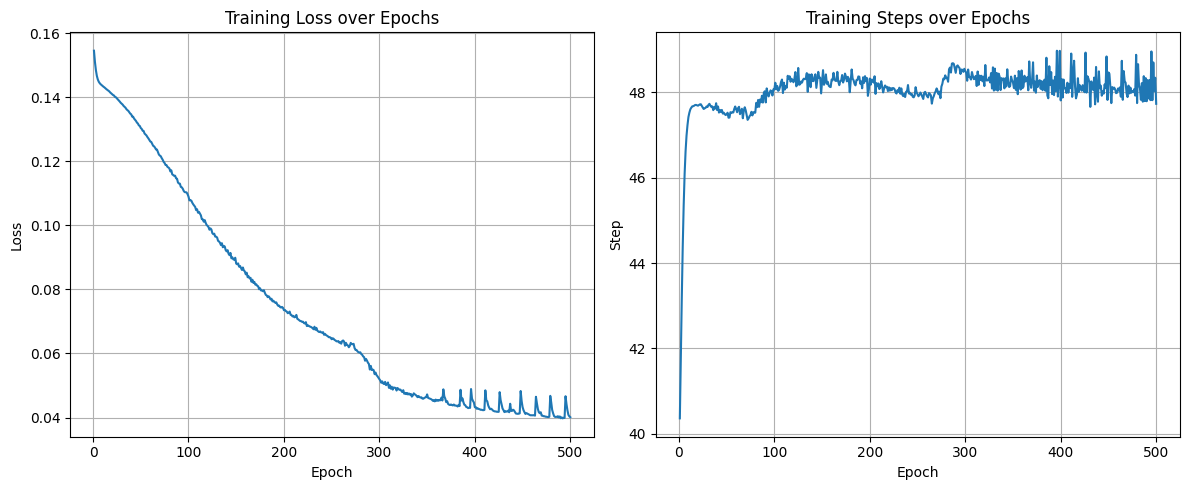

[[[[[ Result Directory: results\DynDiff_lambda0.04_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.1573, Average Diff Step = 45.7170
Epoch: 1, Average Loss = 0.1569, Average Diff Step = 45.8103
Epoch: 2, Average Loss = 0.1568, Average Diff Step = 45.8646
Epoch: 3, Average Loss = 0.1567, Average Diff Step = 45.9059
Epoch: 4, Average Loss = 0.1566, Average Diff Step = 45.9485
Epoch: 5, Average Loss = 0.1565, Average Diff Step = 45.9807
Epoch: 6, Average Loss = 0.1564, Average Diff Step = 45.9948
Epoch: 7, Average Loss = 0.1563, Average Diff Step = 46.0276
Epoch: 8, Average Loss = 0.1562, Average Diff Step = 46.0317
Epoch: 9, Average Loss = 0.1561, Average Diff Step = 46.0471
Epoch: 10, Average Loss = 0.1561, Average Diff Step = 46.0542
Epoch: 11, Average Loss = 0.1560, Average Diff Step = 46.0637
Epoch: 12, Average Loss = 0.1559, Average Diff Step = 46.0693
Epoch: 13, Average Loss = 0.1558, Average Diff Step = 46.0857
Epoch: 14, Average Loss = 0.1557, Average Diff Step = 46.0727
Epoch: 15

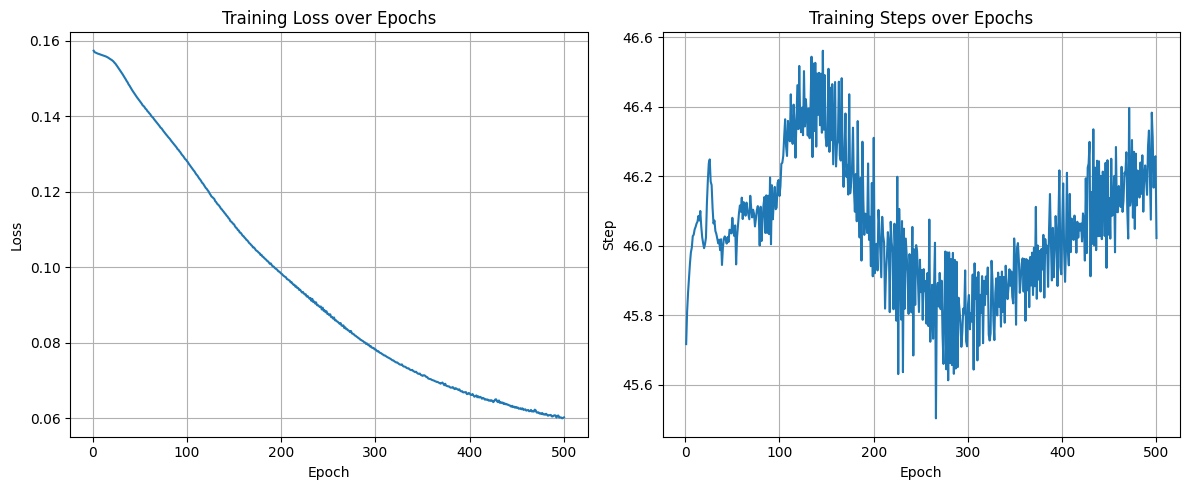

[[[[[ Result Directory: results\DynDiff_lambda0.08_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.1693, Average Diff Step = 46.1604
Epoch: 1, Average Loss = 0.1686, Average Diff Step = 45.9207
Epoch: 2, Average Loss = 0.1683, Average Diff Step = 45.7238
Epoch: 3, Average Loss = 0.1680, Average Diff Step = 45.5472
Epoch: 4, Average Loss = 0.1678, Average Diff Step = 45.3898
Epoch: 5, Average Loss = 0.1675, Average Diff Step = 45.2696
Epoch: 6, Average Loss = 0.1672, Average Diff Step = 45.1983
Epoch: 7, Average Loss = 0.1669, Average Diff Step = 45.1077
Epoch: 8, Average Loss = 0.1666, Average Diff Step = 45.0225
Epoch: 9, Average Loss = 0.1663, Average Diff Step = 44.9748
Epoch: 10, Average Loss = 0.1660, Average Diff Step = 44.9571
Epoch: 11, Average Loss = 0.1656, Average Diff Step = 44.9515
Epoch: 12, Average Loss = 0.1652, Average Diff Step = 44.9662
Epoch: 13, Average Loss = 0.1648, Average Diff Step = 44.9780
Epoch: 14, Average Loss = 0.1643, Average Diff Step = 45.0218
Epoch: 15

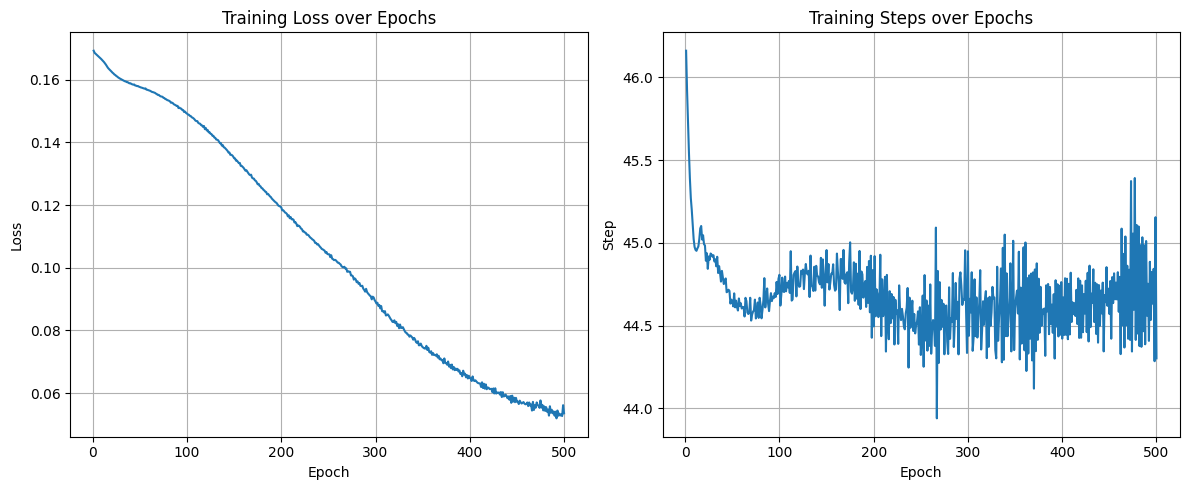

[[[[[ Result Directory: results\DynDiff_lambda0.16_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.1911, Average Diff Step = 40.2866
Epoch: 1, Average Loss = 0.1904, Average Diff Step = 40.5771
Epoch: 2, Average Loss = 0.1900, Average Diff Step = 40.7972
Epoch: 3, Average Loss = 0.1896, Average Diff Step = 40.9651
Epoch: 4, Average Loss = 0.1891, Average Diff Step = 41.1577
Epoch: 5, Average Loss = 0.1888, Average Diff Step = 41.3415
Epoch: 6, Average Loss = 0.1882, Average Diff Step = 41.5550
Epoch: 7, Average Loss = 0.1878, Average Diff Step = 41.7006
Epoch: 8, Average Loss = 0.1874, Average Diff Step = 41.7783
Epoch: 9, Average Loss = 0.1871, Average Diff Step = 41.8609
Epoch: 10, Average Loss = 0.1867, Average Diff Step = 41.9718
Epoch: 11, Average Loss = 0.1863, Average Diff Step = 42.0578
Epoch: 12, Average Loss = 0.1859, Average Diff Step = 42.0912
Epoch: 13, Average Loss = 0.1855, Average Diff Step = 42.0769
Epoch: 14, Average Loss = 0.1851, Average Diff Step = 42.2085
Epoch: 15

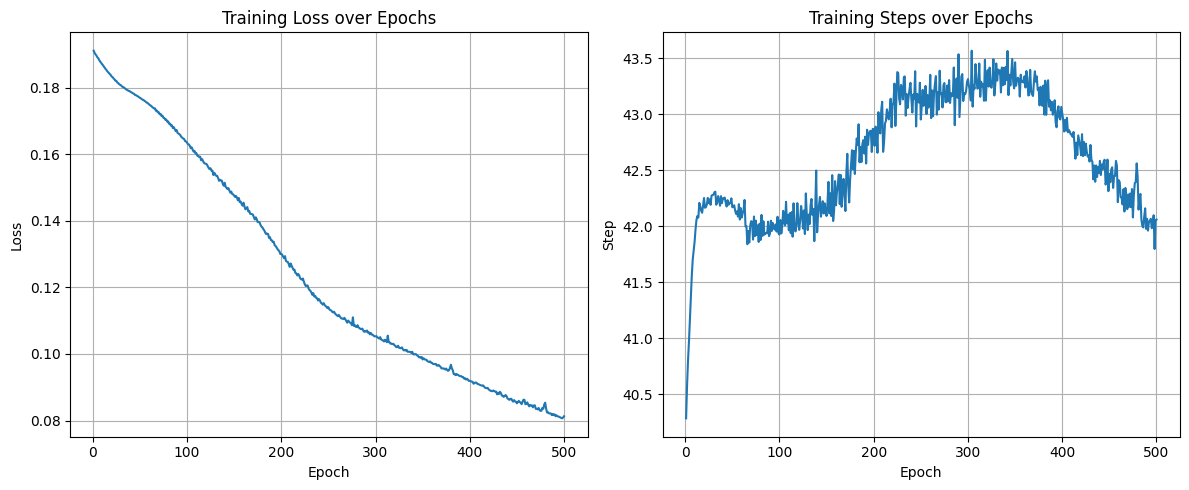

[[[[[ Result Directory: results\DynDiff_lambda0.32_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.2268, Average Diff Step = 36.8417
Epoch: 1, Average Loss = 0.2264, Average Diff Step = 36.8557
Epoch: 2, Average Loss = 0.2261, Average Diff Step = 36.8753
Epoch: 3, Average Loss = 0.2260, Average Diff Step = 36.8637
Epoch: 4, Average Loss = 0.2258, Average Diff Step = 36.8187
Epoch: 5, Average Loss = 0.2256, Average Diff Step = 36.8286
Epoch: 6, Average Loss = 0.2254, Average Diff Step = 36.8069
Epoch: 7, Average Loss = 0.2252, Average Diff Step = 36.7934
Epoch: 8, Average Loss = 0.2250, Average Diff Step = 36.8107
Epoch: 9, Average Loss = 0.2248, Average Diff Step = 36.7646
Epoch: 10, Average Loss = 0.2245, Average Diff Step = 36.7698
Epoch: 11, Average Loss = 0.2242, Average Diff Step = 36.7408
Epoch: 12, Average Loss = 0.2239, Average Diff Step = 36.7674
Epoch: 13, Average Loss = 0.2237, Average Diff Step = 36.7604
Epoch: 14, Average Loss = 0.2234, Average Diff Step = 36.7786
Epoch: 15

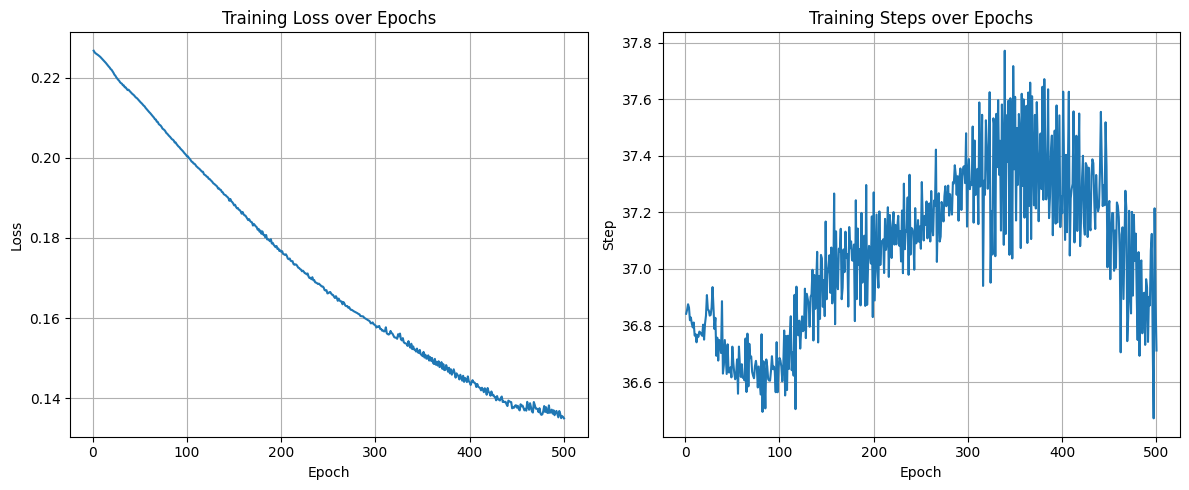

[[[[[ Result Directory: results\DynDiff_lambda0.64_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.2986, Average Diff Step = 38.6122
Epoch: 1, Average Loss = 0.2888, Average Diff Step = 36.0951
Epoch: 2, Average Loss = 0.2827, Average Diff Step = 33.6521
Epoch: 3, Average Loss = 0.2801, Average Diff Step = 31.9946
Epoch: 4, Average Loss = 0.2793, Average Diff Step = 31.1210
Epoch: 5, Average Loss = 0.2788, Average Diff Step = 30.6988
Epoch: 6, Average Loss = 0.2785, Average Diff Step = 30.4991
Epoch: 7, Average Loss = 0.2781, Average Diff Step = 30.4015
Epoch: 8, Average Loss = 0.2779, Average Diff Step = 30.3338
Epoch: 9, Average Loss = 0.2775, Average Diff Step = 30.3030
Epoch: 10, Average Loss = 0.2773, Average Diff Step = 30.2722
Epoch: 11, Average Loss = 0.2770, Average Diff Step = 30.2471
Epoch: 12, Average Loss = 0.2767, Average Diff Step = 30.2037
Epoch: 13, Average Loss = 0.2764, Average Diff Step = 30.2170
Epoch: 14, Average Loss = 0.2762, Average Diff Step = 30.1971
Epoch: 15

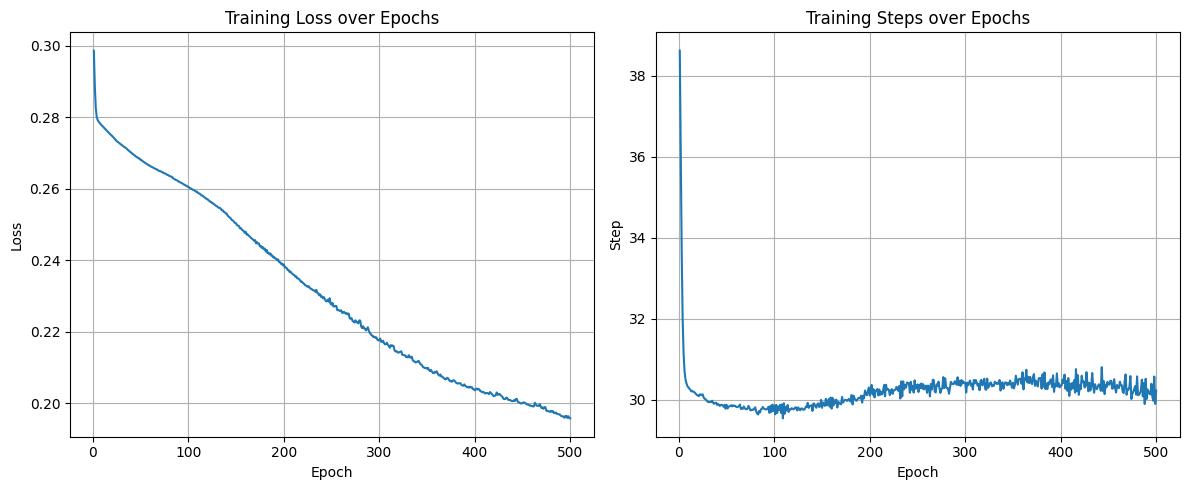

[[[[[ Result Directory: results\DynDiff_lambda1_lr0.001_hid16 ]]]]]
Epoch: 0, Average Loss = 0.3892, Average Diff Step = 39.9280
Epoch: 1, Average Loss = 0.3631, Average Diff Step = 36.9679
Epoch: 2, Average Loss = 0.3346, Average Diff Step = 32.4045
Epoch: 3, Average Loss = 0.3204, Average Diff Step = 28.2497
Epoch: 4, Average Loss = 0.3173, Average Diff Step = 26.1572
Epoch: 5, Average Loss = 0.3167, Average Diff Step = 25.5035
Epoch: 6, Average Loss = 0.3164, Average Diff Step = 25.3030
Epoch: 7, Average Loss = 0.3161, Average Diff Step = 25.2289
Epoch: 8, Average Loss = 0.3158, Average Diff Step = 25.1928
Epoch: 9, Average Loss = 0.3155, Average Diff Step = 25.1728
Epoch: 10, Average Loss = 0.3153, Average Diff Step = 25.1546
Epoch: 11, Average Loss = 0.3150, Average Diff Step = 25.1424
Epoch: 12, Average Loss = 0.3148, Average Diff Step = 25.1279
Epoch: 13, Average Loss = 0.3146, Average Diff Step = 25.1179
Epoch: 14, Average Loss = 0.3144, Average Diff Step = 25.1028
Epoch: 15, A

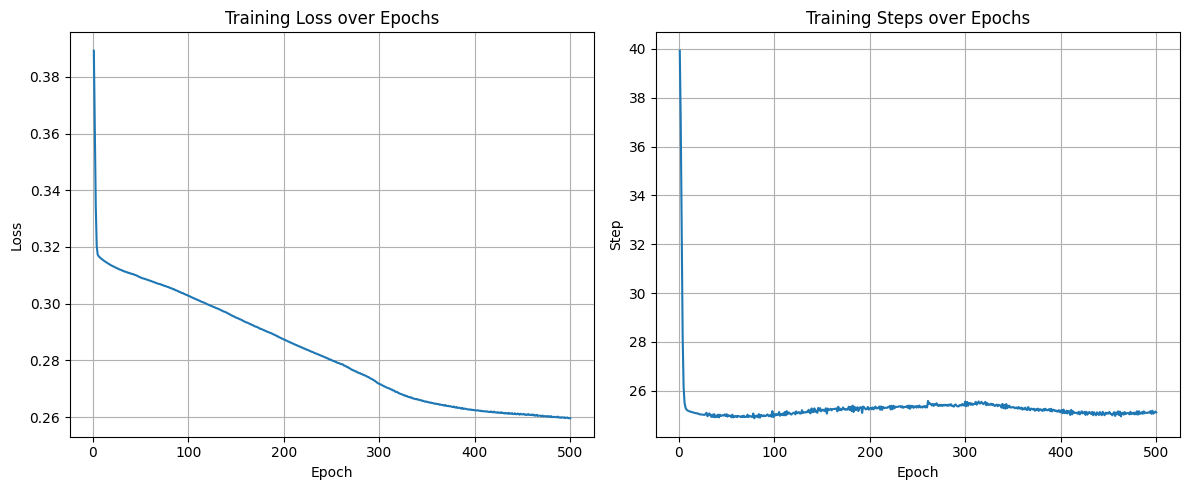

In [80]:
LR = 0.001
HIDDEN_DIM = 16
STEP_LAMBDA = [
    0,
    0.01,
    0.04,
    0.08,
    0.16,
    0.32,
    0.64,
    1
]
for step_lambda in STEP_LAMBDA:
    train_diffstep(500, LR, step_lambda, None, None, HIDDEN_DIM)

### Training Pipeline: Dynamic CFG

In [72]:
CFG_MIN = 0
CFG_MAX = 10
torch.autograd.set_detect_anomaly(True)
def scale_cfg(prediction):
    return prediction*(CFG_MAX - CFG_MIN) + CFG_MIN
def train_cfg(num_epoch, lr, step_lambda, checkpoint_path, name, hidden_dim):
    step_lambda = 0
    if name == None:
        name = f"DynDiff_cfg_lr{lr}_hid{hidden_dim}"

    result_dir = path.join('results', name)
    print(f"[[[[[ Result Directory: {result_dir} ]]]]]")
    os.makedirs(result_dir, exist_ok=(checkpoint_path != None))
    
    if checkpoint_path == None:
        model = FullyConnectedNN(input_dim=INPUT_DIM, hidden_dim=hidden_dim, output_dim=1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        epoch_start = 0
    else:
        checkpoint = torch.load(checkpoint_path)
        # Reinitialize the model and optimizer
        model = FullyConnectedNN(input_dim=INPUT_DIM, hidden_dim=hidden_dim, output_dim=1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # Load the state dictionaries
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']
        
    criterion = StepWithLPIPSLoss(
        loss_map=LOSS_MAP_CFG,
        step_lambda=step_lambda,
        prediction_range=(CFG_MIN,CFG_MAX)).to(device) # usage: loss = loss_fn(prediction, "img_id", (0,10))

    losses = []
    for epoch in range(epoch_start,epoch_start+num_epoch):
        record_file_path = path.join(result_dir, f"record_ep_{epoch}.csv")
        append_to_file(record_file_path, 'id,train_loss,cfg\n')
        model.train()
        loss_sum = 0
        for data in dataset:
            # prepare data
            img_id = data['image_name']
            # semantics = data['semantics']['summary']
            df_row = df_combined[df_combined['id'] == img_id].drop(columns=['id'])
            input_tensor = torch.tensor(df_row.values, dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            outputs = model(input_tensor) # shape: (BATCH SIZE=1, 1)

            cfg = scale_cfg(outputs[0,0].item())

            loss = criterion(outputs, img_id)
            loss.backward()
            optimizer.step()

            append_to_file(record_file_path, f'{img_id},{loss.item()},{cfg}\n')
            loss_sum += loss.item()

        print(f"Epoch: {epoch}, Average Loss = {loss_sum/len(dataset):.4f}")
        losses.append( loss_sum/len(dataset) )
        # Save the model checkpoint
        checkpoint_path = path.join(result_dir, f'model_checkpoint_ep_{epoch}.pth')
        torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)

    plt.figure(figsize=(6, 5))
    plt.plot([(e+1) for e in range(num_epoch)], losses, linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.savefig(path.join(result_dir, "training_loss.png"))
    plt.show()
    
    return model

[[[[[ Result Directory: results\DynDiff_cfg_lr0.002_hid16 ]]]]]
Epoch: 0, Average Loss = 0.0772
Epoch: 1, Average Loss = 0.0557
Epoch: 2, Average Loss = 0.0516
Epoch: 3, Average Loss = 0.0510
Epoch: 4, Average Loss = 0.0507
Epoch: 5, Average Loss = 0.0505
Epoch: 6, Average Loss = 0.0504
Epoch: 7, Average Loss = 0.0502
Epoch: 8, Average Loss = 0.0501
Epoch: 9, Average Loss = 0.0499
Epoch: 10, Average Loss = 0.0498
Epoch: 11, Average Loss = 0.0497
Epoch: 12, Average Loss = 0.0496
Epoch: 13, Average Loss = 0.0495
Epoch: 14, Average Loss = 0.0493
Epoch: 15, Average Loss = 0.0493
Epoch: 16, Average Loss = 0.0492
Epoch: 17, Average Loss = 0.0491
Epoch: 18, Average Loss = 0.0489
Epoch: 19, Average Loss = 0.0488
Epoch: 20, Average Loss = 0.0487
Epoch: 21, Average Loss = 0.0486
Epoch: 22, Average Loss = 0.0485
Epoch: 23, Average Loss = 0.0484
Epoch: 24, Average Loss = 0.0482
Epoch: 25, Average Loss = 0.0481
Epoch: 26, Average Loss = 0.0481
Epoch: 27, Average Loss = 0.0478
Epoch: 28, Average Los

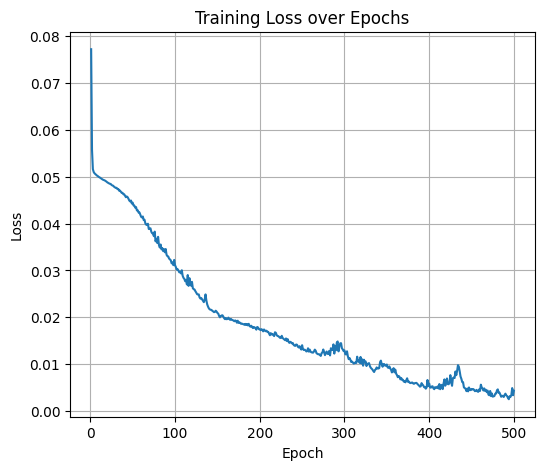

FullyConnectedNN(
  (fc1): Linear(in_features=11, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [81]:
LR = 0.002
HIDDEN_DIM = 16

train_cfg(500, LR, 0, None, None, HIDDEN_DIM)

### Test & Evaluation: Diffusion Step & CFG

In [4]:
# Add the root directory of the repository to the Python path
repo_root = os.path.abspath(os.path.join('DiffBIR'))
sys.path.insert(0, repo_root)
from DiffBIR.sr_helper import initAllDiffusionModel
pipeline_upscale_2 = initAllDiffusionModel(upscale=2)
torch.cuda.empty_cache()

use sdp attention as default
keep default attention mode
[3, 3, 64, 23, 32, 4]
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is None and using 20 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is 1024 and

In [6]:
POS_PROMPT = "Hyper Detail, Masterpiece, 4K"
NEG_PROMPT = "Blurry, Low Quality"

result_dirs = [
    'DynDiff_lambda0_lr0.001_hid16',
    # 'DynDiff_lambda0.01_lr0.001_hid16',
    'DynDiff_lambda0.04_lr0.001_hid16',
    # 'DynDiff_lambda0.08_lr0.001_hid16',
    'DynDiff_lambda0.16_lr0.001_hid16',
    # 'DynDiff_lambda0.32_lr0.001_hid16',
    'DynDiff_lambda0.64_lr0.001_hid16',
    'DynDiff_lambda1_lr0.001_hid16'
]
record_filename = 'record_ep_499.csv'

for setting in result_dirs:
    print(f"Reconstructing Images with Settings: {setting}")
    result_dir = path.join('results', setting)
    record_df = pd.read_csv(path.join(result_dir, record_filename))
    
    for data in dataset:
        # prepare data
        img_id = data['image_name']
        diff_step = record_df.loc[record_df['id'] == img_id, 'step'].values[0]
        diff_step = int(diff_step)
        print(f"{img_id}: {diff_step} steps")
        semantics = data['semantics']['summary']
        vae_img_path = path.join(VAE_DIR, path.basename(data['image_path']))
        CFG = 4
        vae_img = np.array(Image.open(vae_img_path).convert("RGB"))
        sample_img, sample_tensor = pipeline_upscale_2.run(
            vae_img[None], diff_step, 1.0, False,
            512, 256,
            f"{semantics}, {POS_PROMPT}", NEG_PROMPT, CFG,
            False
        )
        recon_img = Image.fromarray(sample_img[0])
        recon_img.save(path.join(result_dir, f"{img_id}.png"))

Reconstructing Images with Settings: DynDiff_lambda0_lr0.001_hid16
alberto-montalesi-176097: 69 steps


C:\Users\CrashedBboy\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 69/69 [13:51<00:00, 12.05s/it]


alejandro-escamilla-6: 35 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 35/35 [07:21<00:00, 12.61s/it]


ales-krivec-15949: 16 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 16/16 [03:25<00:00, 12.87s/it]


alexander-shustov-73: 71 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 71/71 [16:25<00:00, 13.88s/it]


allef-vinicius-109434: 23 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 23/23 [04:49<00:00, 12.60s/it]


amy-zhang-15940: 61 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 61/61 [12:50<00:00, 12.63s/it]


andrew-ruiz-376: 24 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 24/24 [05:01<00:00, 12.56s/it]


benjamin-sloth-lindgreen-705: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [12:37<00:00, 12.62s/it]


casey-fyfe-999: 56 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 56/56 [11:47<00:00, 12.63s/it]


clem-onojeghuo-33741: 65 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 65/65 [13:42<00:00, 12.65s/it]


daniel-robert-405: 65 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 65/65 [13:41<00:00, 12.64s/it]


davide-ragusa-716: 54 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 54/54 [11:22<00:00, 12.64s/it]


dogancan-ozturan-395: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:10<00:00, 12.64s/it]


felix-russell-saw-140699: 71 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 71/71 [14:56<00:00, 12.63s/it]


gian-reto-tarnutzer-45212: 30 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.57s/it]


jared-erondu-21325: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:09<00:00, 12.63s/it]


jason-briscoe-149782: 66 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 66/66 [13:53<00:00, 12.63s/it]


jeremy-cai-1174: 37 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 37/37 [07:46<00:00, 12.60s/it]


juskteez-vu-1041: 57 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 57/57 [12:01<00:00, 12.66s/it]


kazuend-28556: 20 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.52s/it]


lobostudio-hamburg-75377: 22 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 22/22 [04:35<00:00, 12.53s/it]


martin-wessely-211: 32 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 32/32 [06:42<00:00, 12.58s/it]


martyn-seddon-220: 78 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 78/78 [16:25<00:00, 12.63s/it]


michael-durana-82941: 31 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 31/31 [06:29<00:00, 12.57s/it]


mullermarc-184: 77 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 77/77 [16:13<00:00, 12.64s/it]


nomao-saeki-33553: 21 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 21/21 [04:22<00:00, 12.52s/it]


paul-itkin-46101: 79 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 79/79 [16:38<00:00, 12.64s/it]


philipp-reiner-207: 44 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 44/44 [09:14<00:00, 12.60s/it]


philippe-wuyts-45997: 36 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 36/36 [07:33<00:00, 12.59s/it]


roberto-nickson-48063: 17 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 17/17 [03:32<00:00, 12.49s/it]


schicka-307: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.33s/it]


sergey-zolkin-1045: 52 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 52/52 [10:55<00:00, 12.62s/it]


sergey-zolkin-21232: 17 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 17/17 [03:32<00:00, 12.49s/it]


stefan-kunze-26931: 65 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 65/65 [13:40<00:00, 12.63s/it]


thong-vo-428: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:09<00:00, 12.63s/it]


todd-quackenbush-222: 31 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 31/31 [06:29<00:00, 12.58s/it]


todd-quackenbush-27493: 5 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.04s/it]


veeterzy-82537: 76 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 76/76 [16:10<00:00, 12.77s/it]


vita-vilcina-3055: 51 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 51/51 [10:52<00:00, 12.79s/it]


wojciech-szaturski-3611: 67 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 67/67 [14:16<00:00, 12.79s/it]


zugr-108: 25 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 25/25 [05:17<00:00, 12.70s/it]


Reconstructing Images with Settings: DynDiff_lambda0.04_lr0.001_hid16
alberto-montalesi-176097: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [14:53<00:00, 12.77s/it]


alejandro-escamilla-6: 29 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 29/29 [06:04<00:00, 12.57s/it]


ales-krivec-15949: 19 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 19/19 [03:59<00:00, 12.62s/it]


alexander-shustov-73: 63 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 63/63 [13:15<00:00, 12.63s/it]


allef-vinicius-109434: 10 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.36s/it]


amy-zhang-15940: 61 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 61/61 [12:50<00:00, 12.63s/it]


andrew-ruiz-376: 18 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 18/18 [03:44<00:00, 12.50s/it]


benjamin-sloth-lindgreen-705: 54 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 54/54 [11:21<00:00, 12.62s/it]


casey-fyfe-999: 77 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 77/77 [16:14<00:00, 12.66s/it]


clem-onojeghuo-33741: 62 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 62/62 [13:02<00:00, 12.62s/it]


daniel-robert-405: 56 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 56/56 [11:46<00:00, 12.62s/it]


davide-ragusa-716: 53 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 53/53 [11:10<00:00, 12.64s/it]


dogancan-ozturan-395: 69 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 69/69 [14:32<00:00, 12.64s/it]


felix-russell-saw-140699: 61 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 61/61 [12:50<00:00, 12.63s/it]


gian-reto-tarnutzer-45212: 48 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 48/48 [10:07<00:00, 12.65s/it]


jared-erondu-21325: 58 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 58/58 [12:15<00:00, 12.69s/it]


jason-briscoe-149782: 69 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 69/69 [14:34<00:00, 12.67s/it]


jeremy-cai-1174: 38 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 38/38 [08:04<00:00, 12.75s/it]


juskteez-vu-1041: 60 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 60/60 [12:46<00:00, 12.78s/it]


kazuend-28556: 10 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.51s/it]


lobostudio-hamburg-75377: 8 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:39<00:00, 12.46s/it]


martin-wessely-211: 32 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 32/32 [06:47<00:00, 12.73s/it]


martyn-seddon-220: 71 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 71/71 [15:08<00:00, 12.79s/it]


michael-durana-82941: 32 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 32/32 [06:48<00:00, 12.75s/it]


mullermarc-184: 75 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 75/75 [15:59<00:00, 12.79s/it]


nomao-saeki-33553: 5 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.19s/it]


paul-itkin-46101: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:21<00:00, 12.79s/it]


philipp-reiner-207: 40 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 40/40 [08:30<00:00, 12.75s/it]


philippe-wuyts-45997: 39 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 39/39 [08:17<00:00, 12.75s/it]


roberto-nickson-48063: 15 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 15/15 [03:09<00:00, 12.62s/it]


schicka-307: 26 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 26/26 [05:31<00:00, 12.74s/it]


sergey-zolkin-1045: 63 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 63/63 [13:25<00:00, 12.78s/it]


sergey-zolkin-21232: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:52<00:00, 12.48s/it]


stefan-kunze-26931: 51 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 51/51 [10:52<00:00, 12.79s/it]


thong-vo-428: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [14:55<00:00, 12.79s/it]


todd-quackenbush-222: 46 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 46/46 [09:47<00:00, 12.76s/it]


todd-quackenbush-27493: 22 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 22/22 [04:39<00:00, 12.72s/it]


veeterzy-82537: 65 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 65/65 [13:54<00:00, 12.84s/it]


vita-vilcina-3055: 59 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 59/59 [13:42<00:00, 13.94s/it]


wojciech-szaturski-3611: 54 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 54/54 [12:06<00:00, 13.46s/it]


zugr-108: 28 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 28/28 [06:17<00:00, 13.49s/it]


Reconstructing Images with Settings: DynDiff_lambda0.16_lr0.001_hid16
alberto-montalesi-176097: 54 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 54/54 [11:31<00:00, 12.80s/it]


alejandro-escamilla-6: 30 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:50<00:00, 13.68s/it]


ales-krivec-15949: 4 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.40s/it]


alexander-shustov-73: 55 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 55/55 [12:51<00:00, 14.02s/it]


allef-vinicius-109434: 8 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:54<00:00, 14.29s/it]


amy-zhang-15940: 53 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 53/53 [11:21<00:00, 12.86s/it]


andrew-ruiz-376: 15 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 15/15 [03:08<00:00, 12.54s/it]


benjamin-sloth-lindgreen-705: 44 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 44/44 [09:17<00:00, 12.67s/it]


casey-fyfe-999: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:15<00:00, 12.72s/it]


clem-onojeghuo-33741: 62 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 62/62 [13:04<00:00, 12.66s/it]


daniel-robert-405: 59 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 59/59 [12:28<00:00, 12.69s/it]


davide-ragusa-716: 53 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 53/53 [11:08<00:00, 12.62s/it]


dogancan-ozturan-395: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:10<00:00, 12.64s/it]


felix-russell-saw-140699: 72 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 72/72 [15:09<00:00, 12.64s/it]


gian-reto-tarnutzer-45212: 24 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 24/24 [05:01<00:00, 12.55s/it]


jared-erondu-21325: 78 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 78/78 [16:26<00:00, 12.65s/it]


jason-briscoe-149782: 61 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 61/61 [12:50<00:00, 12.63s/it]


jeremy-cai-1174: 33 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 33/33 [06:55<00:00, 12.59s/it]


juskteez-vu-1041: 53 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 53/53 [11:09<00:00, 12.62s/it]


kazuend-28556: 11 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 11/11 [02:16<00:00, 12.39s/it]


lobostudio-hamburg-75377: 8 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:38<00:00, 12.28s/it]


martin-wessely-211: 55 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 55/55 [11:34<00:00, 12.63s/it]


martyn-seddon-220: 66 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 66/66 [13:54<00:00, 12.64s/it]


michael-durana-82941: 14 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 14/14 [02:54<00:00, 12.45s/it]


mullermarc-184: 55 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 55/55 [11:42<00:00, 12.78s/it]


nomao-saeki-33553: 8 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:39<00:00, 12.44s/it]


paul-itkin-46101: 62 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 62/62 [13:14<00:00, 12.82s/it]


philipp-reiner-207: 48 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 48/48 [10:31<00:00, 13.16s/it]


philippe-wuyts-45997: 41 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 41/41 [09:40<00:00, 14.15s/it]


roberto-nickson-48063: 4 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.96s/it]


schicka-307: 22 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 22/22 [05:10<00:00, 14.12s/it]


sergey-zolkin-1045: 39 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 39/39 [09:29<00:00, 14.61s/it]


sergey-zolkin-21232: 7 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.86s/it]


stefan-kunze-26931: 53 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 53/53 [12:18<00:00, 13.93s/it]


thong-vo-428: 70 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 70/70 [15:13<00:00, 13.05s/it]


todd-quackenbush-222: 28 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 28/28 [05:52<00:00, 12.57s/it]


todd-quackenbush-27493: 16 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 16/16 [03:19<00:00, 12.49s/it]


veeterzy-82537: 68 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 68/68 [14:21<00:00, 12.67s/it]


vita-vilcina-3055: 51 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 51/51 [10:52<00:00, 12.79s/it]


wojciech-szaturski-3611: 55 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 55/55 [11:43<00:00, 12.79s/it]


zugr-108: 23 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 23/23 [04:52<00:00, 12.71s/it]


Reconstructing Images with Settings: DynDiff_lambda0.64_lr0.001_hid16
alberto-montalesi-176097: 39 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 39/39 [08:18<00:00, 12.77s/it]


alejandro-escamilla-6: 19 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 19/19 [04:00<00:00, 12.68s/it]


ales-krivec-15949: 7 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 7/7 [01:26<00:00, 12.39s/it]


alexander-shustov-73: 37 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 37/37 [07:52<00:00, 12.76s/it]


allef-vinicius-109434: 4 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.04s/it]


amy-zhang-15940: 41 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 41/41 [08:40<00:00, 12.69s/it]


andrew-ruiz-376: 14 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 14/14 [02:56<00:00, 12.58s/it]


benjamin-sloth-lindgreen-705: 38 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 38/38 [07:58<00:00, 12.60s/it]


casey-fyfe-999: 51 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 51/51 [10:43<00:00, 12.62s/it]


clem-onojeghuo-33741: 47 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 47/47 [09:55<00:00, 12.67s/it]


daniel-robert-405: 35 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 35/35 [07:20<00:00, 12.59s/it]


davide-ragusa-716: 36 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 36/36 [07:36<00:00, 12.67s/it]


dogancan-ozturan-395: 43 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 43/43 [09:02<00:00, 12.62s/it]


felix-russell-saw-140699: 49 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 49/49 [10:21<00:00, 12.67s/it]


gian-reto-tarnutzer-45212: 15 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 15/15 [03:07<00:00, 12.47s/it]


jared-erondu-21325: 47 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 47/47 [09:53<00:00, 12.62s/it]


jason-briscoe-149782: 41 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 41/41 [08:36<00:00, 12.61s/it]


jeremy-cai-1174: 24 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 24/24 [05:01<00:00, 12.55s/it]


juskteez-vu-1041: 38 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 38/38 [07:58<00:00, 12.60s/it]


kazuend-28556: 5 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.36s/it]


lobostudio-hamburg-75377: 6 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.15s/it]


martin-wessely-211: 41 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 41/41 [08:37<00:00, 12.62s/it]


martyn-seddon-220: 46 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 46/46 [09:43<00:00, 12.68s/it]


michael-durana-82941: 11 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 11/11 [02:16<00:00, 12.40s/it]


mullermarc-184: 48 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 48/48 [10:05<00:00, 12.62s/it]


nomao-saeki-33553: 7 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 7/7 [01:25<00:00, 12.23s/it]


paul-itkin-46101: 48 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 48/48 [10:05<00:00, 12.62s/it]


philipp-reiner-207: 38 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 38/38 [07:58<00:00, 12.60s/it]


philippe-wuyts-45997: 27 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 27/27 [05:39<00:00, 12.56s/it]


roberto-nickson-48063: 4 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.69s/it]


schicka-307: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.33s/it]


sergey-zolkin-1045: 27 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 27/27 [05:39<00:00, 12.57s/it]


sergey-zolkin-21232: 7 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 7/7 [01:25<00:00, 12.23s/it]


stefan-kunze-26931: 43 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 43/43 [09:03<00:00, 12.65s/it]


thong-vo-428: 48 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 48/48 [10:05<00:00, 12.62s/it]


todd-quackenbush-222: 22 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 22/22 [04:35<00:00, 12.54s/it]


todd-quackenbush-27493: 6 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.16s/it]


veeterzy-82537: 46 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 46/46 [09:40<00:00, 12.61s/it]


vita-vilcina-3055: 48 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 48/48 [10:06<00:00, 12.63s/it]


wojciech-szaturski-3611: 46 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 46/46 [09:40<00:00, 12.62s/it]


zugr-108: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.33s/it]


Reconstructing Images with Settings: DynDiff_lambda1_lr0.001_hid16
alberto-montalesi-176097: 29 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 29/29 [06:06<00:00, 12.63s/it]


alejandro-escamilla-6: 11 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 11/11 [02:18<00:00, 12.60s/it]


ales-krivec-15949: 11 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 11/11 [02:16<00:00, 12.39s/it]


alexander-shustov-73: 34 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 34/34 [07:08<00:00, 12.60s/it]


allef-vinicius-109434: 12 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 12/12 [02:29<00:00, 12.42s/it]


amy-zhang-15940: 32 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 32/32 [06:42<00:00, 12.58s/it]


andrew-ruiz-376: 10 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.36s/it]


benjamin-sloth-lindgreen-705: 24 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 24/24 [05:03<00:00, 12.64s/it]


casey-fyfe-999: 40 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 40/40 [08:25<00:00, 12.65s/it]


clem-onojeghuo-33741: 36 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 36/36 [07:33<00:00, 12.60s/it]


daniel-robert-405: 29 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 29/29 [06:04<00:00, 12.58s/it]


davide-ragusa-716: 31 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 31/31 [06:30<00:00, 12.58s/it]


dogancan-ozturan-395: 39 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 39/39 [08:13<00:00, 12.67s/it]


felix-russell-saw-140699: 39 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 39/39 [08:11<00:00, 12.61s/it]


gian-reto-tarnutzer-45212: 19 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 19/19 [03:57<00:00, 12.51s/it]


jared-erondu-21325: 44 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 44/44 [09:14<00:00, 12.61s/it]


jason-briscoe-149782: 36 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 36/36 [07:33<00:00, 12.61s/it]


jeremy-cai-1174: 19 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 19/19 [03:59<00:00, 12.62s/it]


juskteez-vu-1041: 30 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:18<00:00, 12.63s/it]


kazuend-28556: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.33s/it]


lobostudio-hamburg-75377: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.33s/it]


martin-wessely-211: 11 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 11/11 [02:16<00:00, 12.40s/it]


martyn-seddon-220: 41 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 41/41 [08:37<00:00, 12.61s/it]


michael-durana-82941: 16 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 16/16 [03:19<00:00, 12.49s/it]


mullermarc-184: 43 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 43/43 [09:02<00:00, 12.61s/it]


nomao-saeki-33553: 11 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 11/11 [02:16<00:00, 12.39s/it]


paul-itkin-46101: 40 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 40/40 [08:24<00:00, 12.61s/it]


philipp-reiner-207: 19 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 19/19 [03:57<00:00, 12.52s/it]


philippe-wuyts-45997: 18 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 18/18 [03:45<00:00, 12.50s/it]


roberto-nickson-48063: 8 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:38<00:00, 12.28s/it]


schicka-307: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.33s/it]


sergey-zolkin-1045: 22 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 22/22 [04:35<00:00, 12.54s/it]


sergey-zolkin-21232: 9 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.32s/it]


stefan-kunze-26931: 36 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 36/36 [07:33<00:00, 12.60s/it]


thong-vo-428: 39 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 39/39 [08:11<00:00, 12.60s/it]


todd-quackenbush-222: 16 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 16/16 [03:19<00:00, 12.49s/it]


todd-quackenbush-27493: 6 steps


Spaced Sampler: 100%|████████████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.15s/it]


veeterzy-82537: 41 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 41/41 [08:40<00:00, 12.69s/it]


vita-vilcina-3055: 31 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 31/31 [06:30<00:00, 12.60s/it]


wojciech-szaturski-3611: 42 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 42/42 [08:49<00:00, 12.61s/it]


zugr-108: 12 steps


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 12/12 [02:29<00:00, 12.42s/it]


In [5]:
POS_PROMPT = "Hyper Detail, Masterpiece, 4K"
NEG_PROMPT = "Blurry, Low Quality"

record_filename = 'record_ep_499.csv'


setting = 'DynDiff_cfg_lr0.002_hid16'
print(f"Reconstructing Images with Settings: {setting}")
result_dir = path.join('results', setting)
record_df = pd.read_csv(path.join(result_dir, record_filename))

for data in dataset[26:]:
    # prepare data
    img_id = data['image_name']
    CFG = record_df.loc[record_df['id'] == img_id, 'cfg'].values[0]
    CFG = float(CFG)
    print(f"{img_id}: CFG {CFG}")
    semantics = data['semantics']['summary']
    DIFF_STEP = 30
    vae_img_path = path.join(VAE_DIR, path.basename(data['image_path']))
    vae_img = np.array(Image.open(vae_img_path).convert("RGB"))
    sample_img, sample_tensor = pipeline_upscale_2.run(
        vae_img[None], DIFF_STEP, 1.0, False,
        512, 256,
        f"{semantics}, {POS_PROMPT}", NEG_PROMPT, CFG,
        False
    )
    recon_img = Image.fromarray(sample_img[0])
    recon_img.save(path.join(result_dir, f"{img_id}.png"))

Reconstructing Images with Settings: DynDiff_cfg_lr0.002_hid16
paul-itkin-46101: CFG 3.789328634738922


C:\Users\CrashedBboy\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:19<00:00, 12.65s/it]


philipp-reiner-207: CFG 6.169989705085754


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:51<00:00, 13.73s/it]


philippe-wuyts-45997: CFG 7.789620757102966


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [07:01<00:00, 14.04s/it]


roberto-nickson-48063: CFG 3.388175070285797


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:44<00:00, 13.50s/it]


schicka-307: CFG 1.7904527485370636


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:53<00:00, 13.77s/it]


sergey-zolkin-1045: CFG 5.462464094161987


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:24<00:00, 12.82s/it]


sergey-zolkin-21232: CFG 3.774196207523346


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.57s/it]


stefan-kunze-26931: CFG 2.317269444465637


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:20<00:00, 12.67s/it]


thong-vo-428: CFG 4.887993335723877


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.58s/it]


todd-quackenbush-222: CFG 3.90165239572525


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.57s/it]


todd-quackenbush-27493: CFG 1.6234295070171356


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.57s/it]


veeterzy-82537: CFG 0.25322200730443


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.59s/it]


vita-vilcina-3055: CFG 1.4451758563518524


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.58s/it]


wojciech-szaturski-3611: CFG 4.004921913146973


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:21<00:00, 12.70s/it]


zugr-108: CFG 0.7005244493484497


Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [06:18<00:00, 12.60s/it]


### Exeprimental Zone

In [3]:
steps = 30
cfg = 4
img = np.array(Image.open(path.abspath(path.join('samples', 'dcb535d6f56922f8d54778b046310443.128.png'))).convert("RGB"))
temp = pipeline_upscale.run(
    img[None], steps, 1.0, False,
    512, 256,
    "Hyper Detail, Masterpiece, 4K", "Blurry, Low Quality", cfg,
    False
)[0]

C:\Users\CrashedBboy\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Spaced Sampler: 100%|██████████████████████████████████████████████████████████████████| 30/30 [05:23<00:00, 10.78s/it]


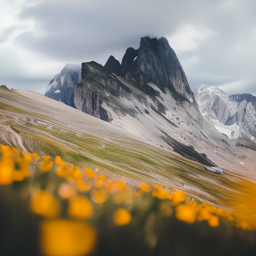

In [4]:
final_img = Image.fromarray(temp)
final_img
# final_img.save(path.join(output_dir, f"{data['image_name']}.final.png"))